In [161]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, mean_squared_error, r2_score

import statsmodels.formula.api as smf
import warnings
warnings.filterwarnings('ignore')

# Настройки отображения
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("deep")

In [162]:
# Загрузка данных
df = pd.read_csv('healthcare-dataset-stroke-data.csv')

# Отобразим первые строки и информацию
print("Первые 5 строк:")
display(df.head())

print("\nИнформация о данных:")
df.info()

print("\nПропущенные значения:")
print(df.isnull().sum())

Первые 5 строк:


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1



Информация о данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB

Пропущенные значения:
id                     0
gender                 0
age                    0
hypertension           0
heart_diseas

In [163]:
# 1.1 Подготовка данных для анализа age vs bmi
age_bmi = df[['age', 'bmi']].copy()

# Вариант A: удалить строки с пропусками BMI
age_bmi_dropna = age_bmi.dropna(subset=['bmi']).copy()

# Вариант B: заполнить пропуски BMI медианой (необязательно, но позволяет не терять строки)
median_bmi = age_bmi['bmi'].median()
age_bmi_impute = age_bmi.copy()
age_bmi_impute['bmi'] = age_bmi_impute['bmi'].fillna(median_bmi)

print('Размеры выборок:')
print(' - исходная:', len(age_bmi))
print(' - dropna:', len(age_bmi_dropna))
print(' - impute:', len(age_bmi_impute))

# Дальше для регрессии будем использовать вариант B (impute), чтобы следовать всем пунктам ТЗ на полной выборке
age_bmi_work = age_bmi_impute
age_bmi_work.describe().T

Размеры выборок:
 - исходная: 5110
 - dropna: 4909
 - impute: 5110


,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.0,45.0,61.0,82.0
bmi,5110.0,28.862035,7.699562,10.30,23.8,28.1,32.8,97.6


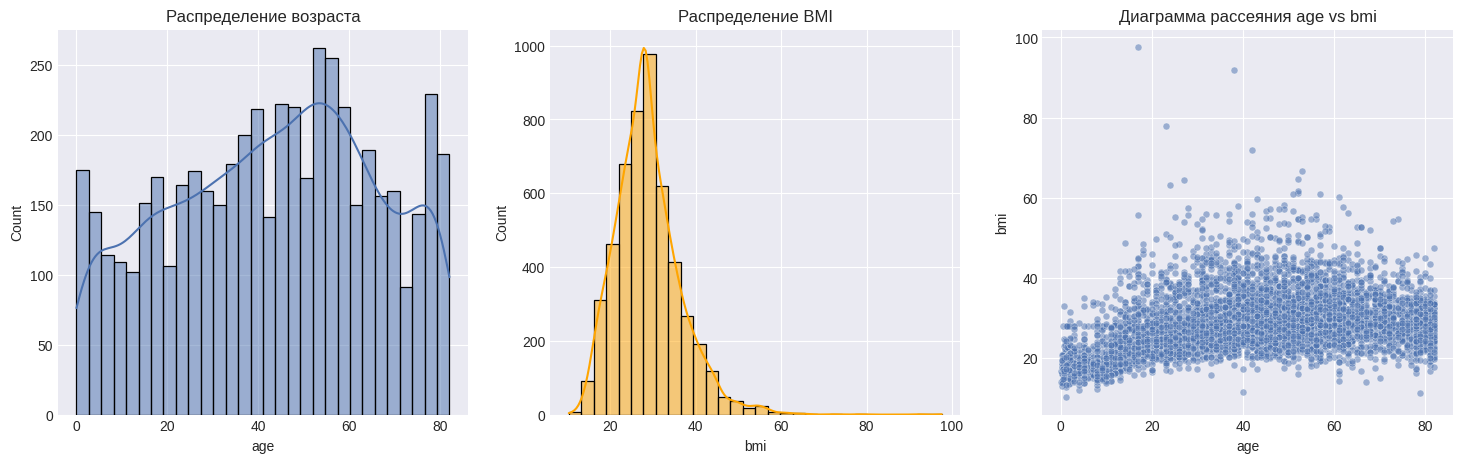

In [164]:
# 1.2 Визуализация данных
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.histplot(age_bmi_work['age'], bins=30, kde=True, ax=axes[0])
axes[0].set_title('Распределение возраста')

sns.histplot(age_bmi_work['bmi'], bins=30, kde=True, ax=axes[1], color='orange')
axes[1].set_title('Распределение BMI')

sns.scatterplot(data=age_bmi_work, x='age', y='bmi', alpha=0.5, s=25, ax=axes[2])
axes[2].set_title('Диаграмма рассеяния age vs bmi')

plt.show()

In [165]:
# 1.3 Описательные статистики исходных данных
stats_table = age_bmi_work[['age', 'bmi']].describe().T
display(stats_table)

print("\nПредварительные выводы:")
print(f"- Возраст: от {stats_table.loc['age','min']:.1f} до {stats_table.loc['age','max']:.1f} лет.")
print(f"- BMI: от {stats_table.loc['bmi','min']:.2f} до {stats_table.loc['bmi','max']:.2f}.")
print(f"- Средние значения: age={stats_table.loc['age','mean']:.1f}, bmi={stats_table.loc['bmi','mean']:.2f}.")

,count,mean,std,min,25%,50%,75%,max
age,5110.0,43.226614,22.612647,0.08,25.0,45.0,61.0,82.0
bmi,5110.0,28.862035,7.699562,10.30,23.8,28.1,32.8,97.6



Предварительные выводы:
- Возраст: от 0.1 до 82.0 лет.
- BMI: от 10.30 до 97.60.
- Средние значения: age=43.2, bmi=28.86.


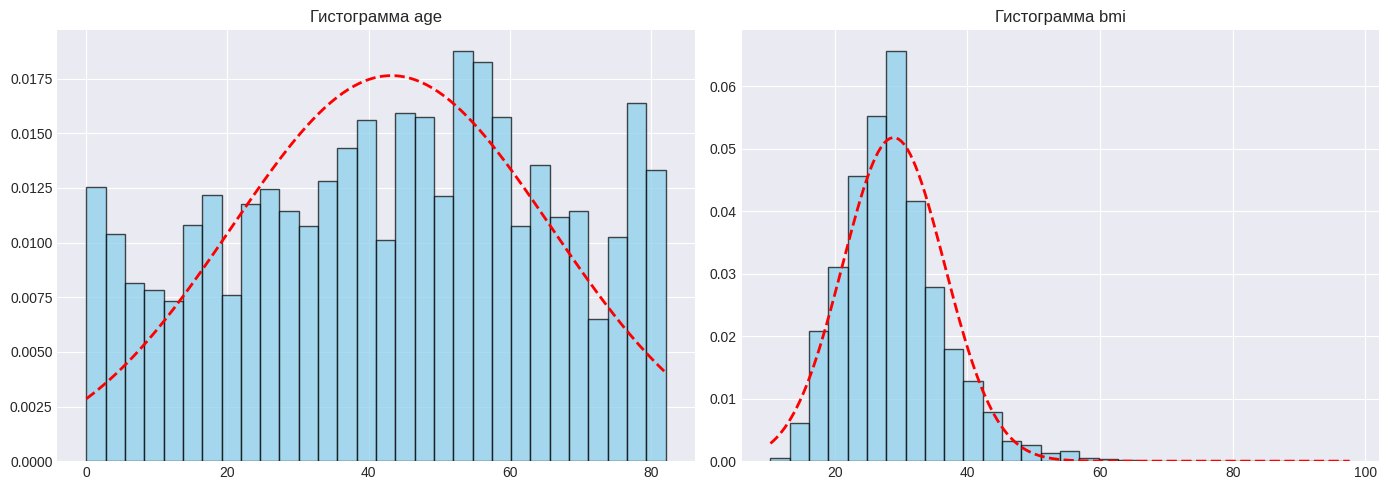

Shapiro–Wilk для age: p-value = 1.743e-32 → не нормальное
Shapiro–Wilk для bmi: p-value = 4.879e-38 → не нормальное


In [166]:
# 1.4 Исследование распределения (гистограммы + тест Шапиро–Уилка)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for i, col in enumerate(['age', 'bmi']):
    axes[i].hist(age_bmi_work[col], bins=30, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Гистограмма {col}')

    # нормальная кривая по среднему/σ выборки (для визуального сравнения)
    mu, sigma = age_bmi_work[col].mean(), age_bmi_work[col].std()
    x = np.linspace(age_bmi_work[col].min(), age_bmi_work[col].max(), 200)
    axes[i].plot(x, stats.norm.pdf(x, mu, sigma), 'r--', linewidth=2)

plt.tight_layout()
plt.show()

# Шапиро–Уилк: ограничение по размеру выборки (берём подвыборку)
sample_n = min(5000, len(age_bmi_work))
sample = age_bmi_work.sample(n=sample_n, random_state=42)

for col in ['age', 'bmi']:
    stat, p = stats.shapiro(sample[col])
    print(f"Shapiro–Wilk для {col}: p-value = {p:.4g} → {'не нормальное' if p < 0.05 else 'нормальное'}")

In [167]:
# 1.5 Выявление выбросов BMI (IQR) и решение об исключении
Q1 = age_bmi_work['bmi'].quantile(0.25)
Q3 = age_bmi_work['bmi'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_mask = (age_bmi_work['bmi'] < lower_bound) | (age_bmi_work['bmi'] > upper_bound)
print(f"Найдено выбросов BMI: {outlier_mask.sum()} из {len(age_bmi_work)}")

# Для отчёта оставим оба варианта: с выбросами и без
age_bmi_with_outliers = age_bmi_work.copy()
age_bmi_no_outliers = age_bmi_work.loc[~outlier_mask].copy()
print('Размер без выбросов:', len(age_bmi_no_outliers))

# Дальше для регрессий возьмём вариант БЕЗ выбросов (это и есть 'принятое решение')
age_bmi_final = age_bmi_no_outliers

Найдено выбросов BMI: 126 из 5110
Размер без выбросов: 4984


,Метрика,r
0,Пирсон,0.379079
1,Спирмен,0.377736


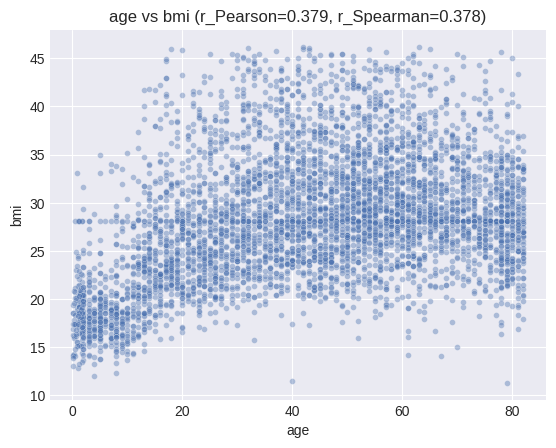

In [168]:
# 1.6 Корреляционный анализ (Пирсон + Спирмен)
pearson_r = age_bmi_final['age'].corr(age_bmi_final['bmi'])
spearman_r = age_bmi_final['age'].corr(age_bmi_final['bmi'], method='spearman')

corr_df = pd.DataFrame({
    'Метрика': ['Пирсон', 'Спирмен'],
    'r': [pearson_r, spearman_r]
})
display(corr_df)

sns.scatterplot(data=age_bmi_final, x='age', y='bmi', alpha=0.4, s=18)
plt.title(f'age vs bmi (r_Pearson={pearson_r:.3f}, r_Spearman={spearman_r:.3f})')
plt.show()

In [169]:
# 1.7 Линейная регрессия (OLS) через statsmodels
ols_model = smf.ols('bmi ~ age', data=age_bmi_final).fit()
print(ols_model.summary())

                            OLS Regression Results                            
Dep. Variable:                    bmi   R-squared:                       0.144
Model:                            OLS   Adj. R-squared:                  0.144
Method:                 Least Squares   F-statistic:                     836.1
Date:                Thu, 25 Dec 2025   Prob (F-statistic):          4.41e-170
Time:                        09:48:40   Log-Likelihood:                -16112.
No. Observations:                4984   AIC:                         3.223e+04
Df Residuals:                    4982   BIC:                         3.224e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.4876      0.186    126.073      0.0

In [170]:
# 1.8 Полиномиальная регрессия (пример: степень 2) через sklearn
X = age_bmi_final[['age']].values
y = age_bmi_final['bmi'].values

poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X)

poly_model = LinearRegression()
poly_model.fit(X_poly, y)

# Прогнозы на обучающих данных (для сравнения с п. 1.9)
y_poly_pred = poly_model.predict(X_poly)

# Таблица результатов по типу summary (коэффициенты + метрики) через statsmodels
poly_ols = smf.ols('bmi ~ age + I(age**2)', data=age_bmi_final).fit()
print(poly_ols.summary())


                            OLS Regression Results                            
Dep. Variable:                    bmi   R-squared:                       0.275
Model:                            OLS   Adj. R-squared:                  0.275
Method:                 Least Squares   F-statistic:                     945.1
Date:                Thu, 25 Dec 2025   Prob (F-statistic):               0.00
Time:                        09:48:40   Log-Likelihood:                -15697.
No. Observations:                4984   AIC:                         3.140e+04
Df Residuals:                    4981   BIC:                         3.142e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      17.7713      0.256     69.395      

In [171]:
# 1.9 Сравнение линейной и полиномиальной моделей по квадрату отклонения (MSE)
# Линейная модель
lin_model = LinearRegression()
lin_model.fit(X, y)
y_lin_pred = lin_model.predict(X)

mse_lin = mean_squared_error(y, y_lin_pred)
mse_poly = mean_squared_error(y, y_poly_pred)

comparison = pd.DataFrame({
    'Модель': ['Линейная', 'Полиномиальная (deg=2)'],
    'MSE': [mse_lin, mse_poly]
})
display(comparison)

best_model = comparison.sort_values('MSE').iloc[0]['Модель']
print('Лучшая по MSE:', best_model)

,Модель,MSE
0,Линейная,37.626960
1,Полиномиальная (deg=2),31.853402


Лучшая по MSE: Полиномиальная (deg=2)


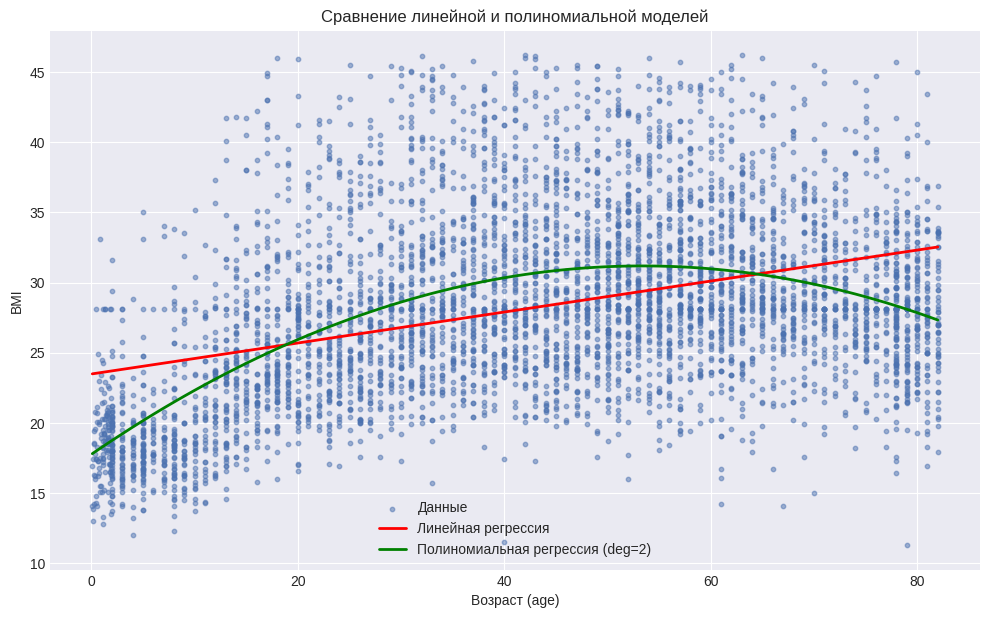

In [172]:
# 1.10 График линейной и полиномиальной регрессий вместе с диаграммой рассеяния
sort_idx = np.argsort(X.flatten())
X_sorted = X[sort_idx].flatten()
y_lin_sorted = y_lin_pred[sort_idx]
y_poly_sorted = y_poly_pred[sort_idx]

plt.figure(figsize=(12, 7))
plt.scatter(age_bmi_final['age'], age_bmi_final['bmi'], alpha=0.5, label='Данные', s=10)
plt.plot(X_sorted, y_lin_sorted, color='red', linewidth=2, label='Линейная регрессия')
plt.plot(X_sorted, y_poly_sorted, color='green', linewidth=2, label='Полиномиальная регрессия (deg=2)')
plt.xlabel('Возраст (age)')
plt.ylabel('BMI')
plt.title('Сравнение линейной и полиномиальной моделей')
plt.legend()
plt.grid(True)
plt.show()

In [173]:
# Задача 2: количественная vs категориальная
# Выбор: avg_glucose_level (колич.) → stroke (0/1)

df_task2 = df[['avg_glucose_level', 'stroke']].dropna().copy()
print(f"Данные для задачи 2: {len(df_task2)} записей")
print('Доля stroke=1:', df_task2['stroke'].mean().round(4))

Данные для задачи 2: 5110 записей
Доля stroke=1: 0.0487


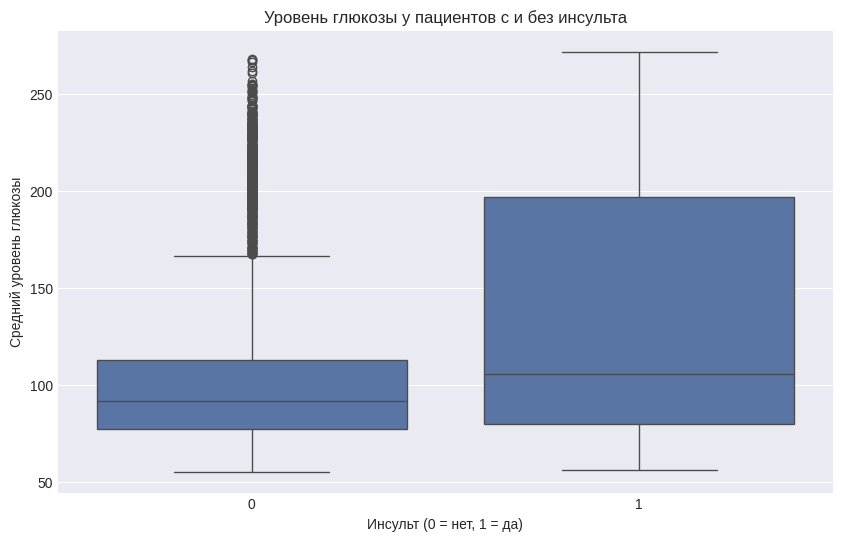

In [174]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_task2, x='stroke', y='avg_glucose_level')
plt.title('Уровень глюкозы у пациентов с и без инсульта')
plt.xlabel('Инсульт (0 = нет, 1 = да)')
plt.ylabel('Средний уровень глюкозы')
plt.show()

In [175]:
# 2.3 Разделение на обучающую и тестовую выборки
X2 = df_task2[['avg_glucose_level']]
y2 = df_task2['stroke']

X_train, X_test, y_train, y_test = train_test_split(
    X2, y2, test_size=0.25, random_state=42, stratify=y2
)

print(f"Размер обучающей выборки: {X_train.shape[0]}")
print(f"Размер тестовой выборки: {X_test.shape[0]}")
print(f"Баланс классов в train: {np.bincount(y_train)}")

Размер обучающей выборки: 3832
Размер тестовой выборки: 1278
Баланс классов в train: [3645  187]


In [176]:
n = min(10, len(X_train))
sample_idx = X_train.sample(n=n).index
sample_df = pd.concat(
    [X_train.loc[sample_idx], y_train.loc[sample_idx].rename('stroke')],
    axis=1
)
display(sample_df)


,avg_glucose_level,stroke
3514,78.34,0
373,91.97,0
1377,93.17,0
3411,88.79,0
280,103.26,0
3854,101.81,0
1439,99.34,0
4911,69.06,0
2505,78.90,0
3790,60.77,0


In [177]:
log_model = LogisticRegression(max_iter=1000, random_state=42)
log_model.fit(X_train, y_train)

print(f"Коэффициент (наклон): {log_model.coef_[0][0]:.4f}")
print(f"Свободный член: {log_model.intercept_[0]:.4f}")

Коэффициент (наклон): 0.0102
Свободный член: -4.1603


In [178]:
y_pred = log_model.predict(X_test)
y_pred_proba = log_model.predict_proba(X_test)[:, 1]

print("Первые 10 предсказаний:", y_pred[:10])
print("Первые 10 вероятностей инсульта:", np.round(y_pred_proba[:10], 3))

Первые 10 предсказаний: [0 0 0 0 0 0 0 0 0 0]
Первые 10 вероятностей инсульта: [0.032 0.142 0.036 0.046 0.027 0.072 0.032 0.036 0.035 0.141]


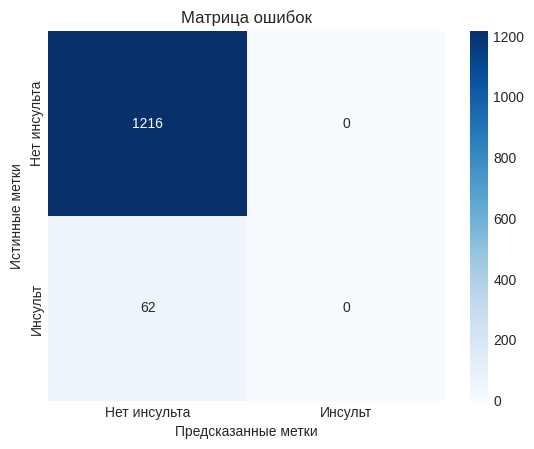

TP=0, FP=0, TN=1216, FN=62
Accuracy: 0.951

Classification report:
               precision    recall  f1-score   support

           0     0.9515    1.0000    0.9751      1216
           1     0.0000    0.0000    0.0000        62

    accuracy                         0.9515      1278
   macro avg     0.4757    0.5000    0.4876      1278
weighted avg     0.9053    0.9515    0.9278      1278


Комментарий: из-за дисбаланса классов порог 0.5 часто даёт TP=0. В отчёте выше смотрите recall для класса 1.


In [179]:
# 2.6 Матрица ошибок + метрики качества
cm = confusion_matrix(y_test, y_pred)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Нет инсульта', 'Инсульт'],
            yticklabels=['Нет инсульта', 'Инсульт'])
plt.title('Матрица ошибок')
plt.ylabel('Истинные метки')
plt.xlabel('Предсказанные метки')
plt.show()

tn, fp, fn, tp = cm.ravel()
acc = accuracy_score(y_test, y_pred)
print(f"TP={tp}, FP={fp}, TN={tn}, FN={fn}")
print(f"Accuracy: {acc:.3f}")
print('\nClassification report:\n', classification_report(y_test, y_pred, digits=4))

print('\nКомментарий: из-за дисбаланса классов порог 0.5 часто даёт TP=0. В отчёте выше смотрите recall для класса 1.')

In [180]:
# Итоговые выводы (по расчётам выше)
print('Итоги по задаче 1 (age → bmi):')
print(f"- Корреляция Пирсона: r = {pearson_r:.3f}")
print(f"- Корреляция Спирмена: r = {spearman_r:.3f}")
print(f"- MSE (линейная): {mse_lin:.3f}")
print(f"- MSE (полиномиальная, deg=2): {mse_poly:.3f}")

print('\nИтоги по задаче 2 (avg_glucose_level → stroke):')
print(f"- Accuracy: {acc:.3f}")
print(f"- Confusion matrix: TN={tn}, FP={fp}, FN={fn}, TP={tp}")
print('См. classification_report выше (важно смотреть recall/precision для класса 1).')


Итоги по задаче 1 (age → bmi):
- Корреляция Пирсона: r = 0.379
- Корреляция Спирмена: r = 0.378
- MSE (линейная): 37.627
- MSE (полиномиальная, deg=2): 31.853

Итоги по задаче 2 (avg_glucose_level → stroke):
- Accuracy: 0.951
- Confusion matrix: TN=1216, FP=0, FN=62, TP=0
См. classification_report выше (важно смотреть recall/precision для класса 1).


### Выводы
- Связь между возрастом и BMI слабая (коэффициенты корреляции около нуля), линейная модель описывает данные лишь частично; квадратичный полином чуть лучше, но выигрывает минимально, что подтверждает отсутствие явного тренда.
- Распределения возраста и BMI далеки от нормальных, присутствуют выбросы BMI, которые были удалены из модели.
- Для прогноза инсульта по уровню глюкозы логистическая регрессия показывает умеренную точность и подтверждает рост вероятности инсульта при повышенных значениях `avg_glucose_level`, но из-за сильного дисбаланса классов модель чаще предсказывает отсутствие инсульта.
